## ロジスティック回帰
- モデルパラメータ（重み）：$\mathbf{w} = (w_0, w_1, w_2, \dots, w_p)^{\mathrm{T}} $
- モデルへの入力：$\mathbf{x} = (1, x_1, x_2, \dots, x_p)^{\mathrm{T}} $
- 以上の2つが与えられたときのモデルの出力（確率値）：$\hat{Y}(\mathbf{x}; \mathbf{w}) =  f(\mathbf{w}^{\mathrm{T}} \mathbf{x})$
  - $f$はシグモイド関数：$f(x) = \frac{1}{1 + \exp(-x)}$

In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix

### 疑似データでScikit-learnによるロジステック回帰

In [6]:
np.random.seed(1234)

# 1つ目のカテゴリに属するデータ
data1 = np.random.multivariate_normal((0, 0), [[4,0],[0,4]], 20)
label1 = np.zeros(len(data1)) # ラベルは0とする

# 2つ目のカテゴリに属するデータ
data2 = np.random.multivariate_normal((4, 4), [[4,0],[0,4]], 20)
label2 = np.ones(len(data2)) # ラベルは1とする

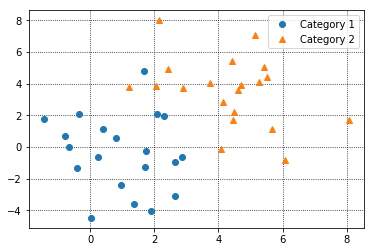

In [7]:
plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')
plt.plot(data1[:, 0], data1[:, 1], 'o', color='C0', label='Category 1')
plt.plot(data2[:, 0], data2[:, 1], '^', color='C1', label='Category 2')
plt.legend(loc='best')
plt.show()

In [8]:
# scikit-learnに渡すため，2つのデータを結合する
X = np.concatenate([data1, data2])
y = np.concatenate([label1, label2])
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234)
clf.fit(X, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}".format(w0, w1, w2))

w0 = -9.077, w1 = 2.595, w2 = 1.220


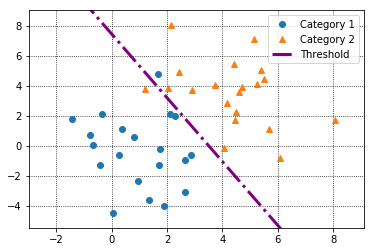

In [9]:
# データをプロット
plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')
plt.plot(data1[:, 0], data1[:, 1], 'o', color='C0', label='Category 1')
plt.plot(data2[:, 0], data2[:, 1], '^', color='C1', label='Category 2')

# 境界線をプロットして表示
# 紫：境界線
x1, x2 = X[:, 0], X[:, 1]
line_x = np.arange(np.min(x1) - 1, np.max(x1) + 1)
line_y = - line_x * w1 / w2 - w0 / w2
plt.plot(line_x, line_y, linestyle='-.', linewidth=3, color='purple', label='Threshold')
plt.ylim([np.min(x2) - 1, np.max(x2) + 1])
plt.legend(loc='best')
plt.show()

In [10]:
# ラベルを予測
y_est = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(-log_loss(y, y_est)))

# 正答率を表示
print('正答率 = {}%'.format(100 * accuracy_score(y, y_est)))

対数尤度 = -1.727
正答率 = 95.0%


In [11]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), index=['正解 = 0', '正解 = 1'], columns=['予測値 = 0', '予測値 = 1'])
conf_mat

,予測値 = 0,予測値 = 1
正解 = 0,19,1
正解 = 1,1,19


### 疑似データでScikit-learnによるロジステック回帰 2
* 実際のデータによく似た疑似データで，説明変数が多次元の場合のロジスティック回帰モデルを構築していきましょう

中古住宅のデータをもう一度使います
* Price : 値段(百万円)
* AreaSize : 土地面積($\mathrm{m}^2$)
* HouseSize : 家面積($\mathrm{m}^2$)
* PassedYear : 経過年数(年)
* Train : 電車での最寄り駅から主要駅までの所要時間(分)
* Walk : 徒歩での最寄り駅から家までの所要時間(分)

In [12]:
df_house = pd.DataFrame({
        "Price":[24.8, 59.5, 7, 7.5, 9.8, 13.5, 14.9, 27, 27, 28, 28.5, 23, 12.9, 18, 23.7, 29.8, 17.8, 5.5, 8.7, 10.3, 14.5, 17.6, 16.8],
        "AreaSize":[98.4, 379.8, 58.6, 61.5, 99.6, 76.2, 115.7, 165.2, 215.2, 157.8, 212.9, 137.8, 87.2, 139.6, 172.6, 151.9, 179.5, 50, 105, 132, 174, 176, 168.7],
        "HouseSize":[74.2, 163.7, 50.5, 58, 66.4, 66.2, 59.6, 98.6, 87.4, 116.9, 96.9, 82.8, 75.1, 77.9, 125, 85.6, 70.1, 48.7, 66.5, 51.9, 82.3, 86.1, 80.8],
        "PassedYear":[4.8, 9.3, 13, 12.8, 14, 6, 14.7, 13.6, 13.3, 6.7, 3.1, 10.3, 11.6, 10.5, 3.8, 5.4, 4.5, 14.6, 13.7, 13, 10.3, 4.4, 12.8],
        "Train":[5, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 19, 23, 23, 23, 28, 32, 37, 37, 37, 37, 37, 41],
        "Walk":[6, 12, 2, 1, 5, 1, 4, 2, 7, 6, 5, 20, 8, 3, 5, 4, 2, 3, 11, 6, 18, 10, 2]
    })
df_house.index.name="id"

# Priceの値を2000万以上なら1，そうでなければ0に変更
df_house['Price'] = df_house['Price'] >= 20

display(df_house)
df_house.describe()

,AreaSize,HouseSize,PassedYear,Price,Train,Walk
id,,,,,,
0,98.4,74.2,4.8,True,5,6
1,379.8,163.7,9.3,True,12,12
2,58.6,50.5,13.0,False,16,2
3,61.5,58.0,12.8,False,16,1
4,99.6,66.4,14.0,False,16,5
5,76.2,66.2,6.0,False,16,1
6,115.7,59.6,14.7,False,16,4
7,165.2,98.6,13.6,True,16,2
8,215.2,87.4,13.3,True,16,7


,AreaSize,HouseSize,PassedYear,Train,Walk
count,23.000000,23.000000,23.000000,23.000000,23.000000
mean,144.139130,81.356522,9.834783,23.260870,6.217391
std,70.086095,26.436955,4.023071,10.247915,5.062846
min,50.000000,48.700000,3.100000,5.000000,1.000000
25%,99.000000,66.300000,5.700000,16.000000,2.500000
50%,139.600000,77.900000,10.500000,19.000000,5.000000
75%,173.300000,86.750000,13.150000,34.500000,7.500000
max,379.800000,163.700000,14.700000,41.000000,20.000000


In [13]:
# 線形回帰のときと同様に説明変数を2つに絞って，ロジスティック回帰
y = df_house["Price"].values
X = df_house[["AreaSize", "Train"]].values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234)
clf.fit(X, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}".format(w0, w1, w2))

w0 = -850.900, w1 = 29.195, w2 = -171.808


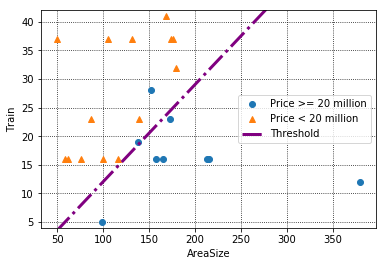

In [14]:
x1, x2 = df_house["AreaSize"].values, df_house["Train"].values 

# データをプロット
plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')

plt.plot(x1[y], x2[y], 'o', color='C0', label='Price >= 20 million')
plt.plot(x1[~y], x2[~y], '^', color='C1', label='Price < 20 million')

# 境界線をプロットして表示
# 紫：境界線
line_x = np.arange(np.min(x1) - 1, np.max(x1) + 1)
line_y = - line_x * w1 / w2 - w0 / w2
plt.plot(line_x, line_y, linestyle='-.', linewidth=3, color='purple', label='Threshold')
plt.ylim([np.min(x2) - 1, np.max(x2) + 1])
plt.legend(loc='best')

plt.xlabel("AreaSize")
plt.ylabel("Train")
plt.show()

In [15]:
# ラベルを予測
y_est = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

対数尤度 = -3.003
正答率 = 91.304%


In [16]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = 2000万未満', '正解 = 2000万以上'], 
                        columns=['予測 = 2000万未満', '予測 = 2000万以上'])
conf_mat

,予測 = 2000万未満,予測 = 2000万以上
正解 = 2000万未満,14,0
正解 = 2000万以上,2,7
